<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка-данных.-Проверка-правильности-расчета-эффективности-обогащения.-Анализ-признаков,-недоступных-в-тестовой-выборке.-Предобработка-данных" data-toc-modified-id="Подготовка-данных.-Проверка-правильности-расчета-эффективности-обогащения.-Анализ-признаков,-недоступных-в-тестовой-выборке.-Предобработка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка данных. Проверка правильности расчета эффективности обогащения. Анализ признаков, недоступных в тестовой выборке. Предобработка данных</a></span></li><li><span><a href="#Анализ-данных" data-toc-modified-id="Анализ-данных-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ данных</a></span></li><li><span><a href="#Модель" data-toc-modified-id="Модель-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Модель</a></span></li><li><span><a href="#Проверка-модели-на-вменяемость" data-toc-modified-id="Проверка-модели-на-вменяемость-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Проверка модели на вменяемость</a></span></li><li><span><a href="#Общий-вывод" data-toc-modified-id="Общий-вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Общий вывод</a></span></li><li><span><a href="#Чек-лист-готовности-проекта" data-toc-modified-id="Чек-лист-готовности-проекта-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Чек-лист готовности проекта</a></span></li></ul></div>

# Восстановление золота из руды

# Описание проекта

Данные в трёх файлах:

gold_recovery_train_new.csv — обучающая выборка;

gold_recovery_test_new.csv — тестовая выборка;

gold_recovery_full_new.csv — исходные данные.

Данные индексируются датой и временем получения информации (признак date). 
Соседние по времени параметры часто похожи. Некоторые параметры недоступны, потому что замеряются и/или рассчитываются значительно позже. 
Из-за этого в тестовой выборке отсутствуют некоторые признаки, которые могут быть в обучающей. 
Также в тестовом наборе нет целевых признаков.
Исходный датасет содержит обучающую и тестовую выборки со всеми признаками.



# Цель проекта:

Подготовить прототип модели машинного обучения для «Цифры». 
Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды. 
Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными 
характеристиками.



# План проекта:

    1. Загрузка, обзор, предобработка данных. Проверка правильности расчета эффективности обогащения.
       Анализ признаков, недоступных в тестовой выборке
       
    2. Анализ данных. Изменение концентрации металлов (Au, Ag, Pb) на различных этапах очистки. 
       Сравнение распределения размеров гранул сырья на обучающей и тестовой выборках. 
       Исследование суммарной концентрации всех веществ на разных стадиях: в сырье, в черновом 
       и финальном концентратах

    3. Построение модели. Функция для вычисления sMAPE. Обучение моделей и их качество. Выбор лучшей модели
   
    4. Проверка модели на вменяемость.

    5. Общий вывод

## Подготовка данных. Проверка правильности расчета эффективности обогащения. Анализ признаков, недоступных в тестовой выборке. Предобработка данных


# 1.1. Подготовка данных

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
from plotly import graph_objects as go

from sklearn.model_selection import train_test_split
from sklearn.pipeline import  make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, make_scorer
from sklearn.model_selection import GridSearchCV,cross_val_score

from sklearn.dummy import DummyRegressor

import warnings
warnings.filterwarnings("ignore")


In [2]:
full = pd.read_csv('/datasets/gold_recovery_full_new.csv', index_col='date')
train = pd.read_csv('/datasets/gold_recovery_train_new.csv', index_col='date') 
test = pd.read_csv('/datasets/gold_recovery_test_new.csv', index_col='date')                   

train.shape, test.shape, full.shape


((14149, 86), (5290, 52), (19439, 86))

Посмотрим описание таблиц:

In [3]:
train.head()

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
date,,,,,,,,,,,,,,,,,,,,,
2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,127.092003,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,125.629232,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,123.819808,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,122.270188,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,117.988169,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691


In [4]:
test.head()

,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
date,,,,,,,,,,,,,,,,,,,,,
2016-09-01 00:59:59,210.800909,14.993118,8.080000,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,-500.704369,...,12.023554,-497.795834,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414
2016-09-01 01:59:59,215.392455,14.987471,8.080000,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,-499.240168,...,12.058140,-498.695773,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438
2016-09-01 02:59:59,215.259946,12.884934,7.786667,0.996043,1398.493666,-500.868360,1398.860436,-499.764529,1398.075709,-502.151509,...,11.962366,-498.767484,8.096893,-500.827423,8.071056,-500.801673,4.905125,-499.828510,24.994862,-500.622559
2016-09-01 03:59:59,215.336236,12.006805,7.640000,0.863514,1399.618111,-498.863574,1397.440120,-499.211024,1400.129303,-498.355873,...,12.033091,-498.350935,8.074946,-499.474407,7.897085,-500.868509,4.931400,-499.963623,24.948919,-498.709987
2016-09-01 04:59:59,199.099327,10.682530,7.530000,0.805575,1401.268123,-500.808305,1398.128818,-499.504543,1402.172226,-500.810606,...,12.025367,-500.786497,8.054678,-500.397500,8.107890,-509.526725,4.957674,-500.360026,25.003331,-500.856333


In [5]:
full.head()

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
date,,,,,,,,,,,,,,,,,,,,,
2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,127.092003,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,125.629232,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,123.819808,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,122.270188,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,117.988169,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691


In [6]:
for data in train, test, full:
    info = data.info()
    print(info)

<class 'pandas.core.frame.DataFrame'>
Index: 14149 entries, 2016-01-15 00:00:00 to 2018-08-18 10:59:59
Data columns (total 86 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   final.output.concentrate_ag                         14148 non-null  float64
 1   final.output.concentrate_pb                         14148 non-null  float64
 2   final.output.concentrate_sol                        13938 non-null  float64
 3   final.output.concentrate_au                         14149 non-null  float64
 4   final.output.recovery                               14149 non-null  float64
 5   final.output.tail_ag                                14149 non-null  float64
 6   final.output.tail_pb                                14049 non-null  float64
 7   final.output.tail_sol                               14144 non-null  float64
 8   final.output.tail_au                             

In [7]:
for data in train, test, full:
    describe = data.describe()
    print(describe)

       final.output.concentrate_ag  final.output.concentrate_pb  \
count                 14148.000000                 14148.000000   
mean                      5.142034                    10.132960   
std                       1.369586                     1.654930   
min                       0.000000                     0.000000   
25%                       4.211620                     9.297355   
50%                       4.994652                    10.297144   
75%                       5.859540                    11.170603   
max                      16.001945                    17.031899   

       final.output.concentrate_sol  final.output.concentrate_au  \
count                  13938.000000                 14149.000000   
mean                       9.202849                    44.003792   
std                        2.790516                     4.905261   
min                        0.000000                     0.000000   
25%                        7.484645                    4

проверяем наличие дубликатов:

In [11]:
for dataset in full, train, test:
    print('Количество дубликатов =', dataset.duplicated().sum())
    print()

Количество дубликатов = 0

Количество дубликатов = 0

Количество дубликатов = 0



Вывод: - во всех представленных таблицах имеются пропуски;

       - в test нет части признаков, которые есть в full и train;
       
       - целевые признаки - rougher.output.recovery и final.output.recovery;

       - дубликатов нет.

# 1.2. Проверка правильности расчета эффективности обогащения

функция для расчета эффективности обогащения:

In [12]:
def recovery_calc(rougher_output, rougher_input, rougher_tail):
    recovery = (rougher_output * (rougher_input - rougher_tail)) \
    / (rougher_input * (rougher_output - rougher_tail)) * 100
    return recovery

Эффективность обогащения на  выборке train для признака rougher.output.recovery:

In [13]:
recovery = recovery_calc(train['rougher.output.concentrate_au'],
                         train['rougher.input.feed_au'],
                         train['rougher.output.tail_au'])
recovery

date
2016-01-15 00:00:00    87.107763
2016-01-15 01:00:00    86.843261
2016-01-15 02:00:00    86.842308
2016-01-15 03:00:00    87.226430
2016-01-15 04:00:00    86.688794
                         ...    
2018-08-18 06:59:59    89.574376
2018-08-18 07:59:59    87.724007
2018-08-18 08:59:59    88.890579
2018-08-18 09:59:59    89.858126
2018-08-18 10:59:59    89.514960
Length: 14149, dtype: float64

Метрика MAE для проверки расчетного значения rougher_output_recovery и табличного:

In [14]:
mae = mean_absolute_error(train['rougher.output.recovery'], recovery)

print('MAE между расчетным значением rougher_output_recovery и табличным =', mae)

MAE между расчетным значением rougher_output_recovery и табличным = 9.73512347450521e-15


Вывод: Полученные значения МАЕ близки к 0, следовательно  эффективность обогащения рассчитана правильно.

# 1.3. Анализ признаков, недоступных в тестовой выборке

Посмотрим, какие признаки есть в train, но нет в test:

In [15]:
train_test = set(train.columns) - set(test.columns)
train[train_test].info()

<class 'pandas.core.frame.DataFrame'>
Index: 14149 entries, 2016-01-15 00:00:00 to 2018-08-18 10:59:59
Data columns (total 34 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   final.output.concentrate_au                         14149 non-null  float64
 1   primary_cleaner.output.tail_sol                     14103 non-null  float64
 2   secondary_cleaner.output.tail_au                    14149 non-null  float64
 3   primary_cleaner.output.tail_ag                      14148 non-null  float64
 4   rougher.output.tail_au                              14149 non-null  float64
 5   final.output.tail_sol                               14144 non-null  float64
 6   rougher.output.tail_pb                              14149 non-null  float64
 7   primary_cleaner.output.concentrate_sol              13863 non-null  float64
 8   secondary_cleaner.output.tail_pb                 

Вывод: - в test нет признаков output, т.к. это целевые признаки;

       - в test нет признаков calculation(расчётные характеристики) для этапа rougher;
       
       - все признаки, которых нет в выборке test - типа float64

# 1.4. Предобработка данных

In [16]:
for dataset in full, train, test:
    print(dataset.isna().sum()[dataset.isna().sum()!=0].sort_values(ascending=False))
  

secondary_cleaner.output.tail_sol             1748
rougher.input.floatbank11_xanthate             453
rougher.state.floatbank10_e_air                436
primary_cleaner.output.concentrate_sol         370
secondary_cleaner.state.floatbank2_a_air       220
                                              ... 
primary_cleaner.state.floatbank8_c_level         1
primary_cleaner.state.floatbank8_b_level         1
primary_cleaner.state.floatbank8_a_level         1
final.output.tail_ag                             1
secondary_cleaner.state.floatbank6_a_level       1
Length: 63, dtype: int64
secondary_cleaner.output.tail_sol             1605
rougher.state.floatbank10_e_air                436
rougher.input.floatbank11_xanthate             428
primary_cleaner.output.concentrate_sol         286
secondary_cleaner.state.floatbank2_a_air       217
                                              ... 
rougher.state.floatbank10_a_air                  1
rougher.state.floatbank10_a_level                1
roughe

в test дабавляю целевые признаки из full по совпадению даты:

In [17]:
test = test.merge(full[['final.output.recovery', 'rougher.output.recovery']], on='date', how='left')
test.shape

(5290, 54)

Соседние по времени параметры часто похожи(по условию), поэтому заполняем следующим непропущенным значением

In [18]:
train = train.fillna(method='bfill')
test = test.fillna(method='bfill')
full = full.fillna(method='bfill')


In [19]:
print('количество строк с пропусками в train :', train.isna().sum().sum())
print('количество строк с пропусками в test :', test.isna().sum().sum())
print('количество строк с пропусками в full :', full.isna().sum().sum())

количество строк с пропусками в train : 0
количество строк с пропусками в test : 0
количество строк с пропусками в full : 0


Вывод: - добавил целевые признаки в  выборку test из full по совпадению даты;

       - подтвердил правильность расчета эффективности обогащения в тренировочной выборке;

       - избавился от пропусков в  выборках;
       
       

## Анализ данных

# 2.1. Изменение концентрации металлов (Ag, Au, Pb) на разных этапах очистки

In [20]:
concentrate_ag = full[['rougher.input.feed_ag',
                       'rougher.output.concentrate_ag',
                       'primary_cleaner.output.concentrate_ag',
                       'final.output.concentrate_ag'
                      ]].mean(axis=0)
concentrate_ag

rougher.input.feed_ag                     8.794927
rougher.output.concentrate_ag            11.994759
primary_cleaner.output.concentrate_ag     8.442408
final.output.concentrate_ag               5.168382
dtype: float64

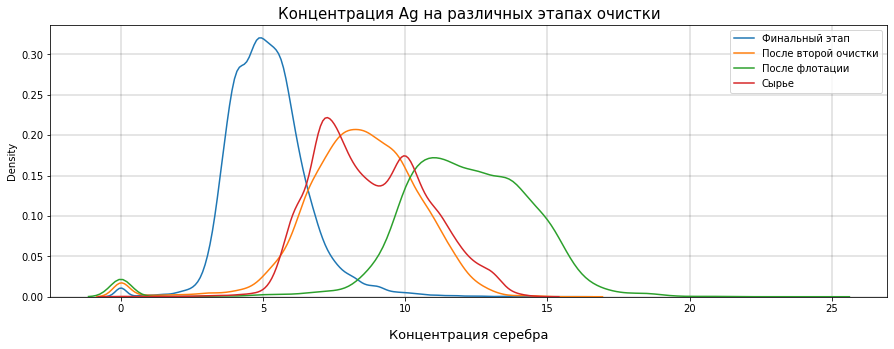

In [21]:
plt.figure(figsize=(15, 5))
plt.title('Концентрация Ag на различных этапах очистки', fontsize=15)
plt.xlabel('Концентрация серебра', labelpad=15, fontsize=13)
sns.kdeplot(data=full['final.output.concentrate_ag'], label = 'Финальный этап')
sns.kdeplot(data=full['primary_cleaner.output.concentrate_ag'], label = 'После второй очистки')
sns.kdeplot(data=full['rougher.output.concentrate_ag'], label = 'После флотации')
sns.kdeplot(data=full['rougher.input.feed_ag'], label = 'Сырье')
plt.grid(which='major',
        color = 'k', 
        linewidth = 0.2)
plt.legend()

plt.show()


In [22]:
concentrate_au = full[['rougher.input.feed_au',
                       'rougher.output.concentrate_au',
                      'primary_cleaner.output.concentrate_au',
                       'final.output.concentrate_au'
                      ]].mean(axis=0)
concentrate_au

rougher.input.feed_au                     8.266097
rougher.output.concentrate_au            19.772000
primary_cleaner.output.concentrate_au    32.119400
final.output.concentrate_au              44.076513
dtype: float64

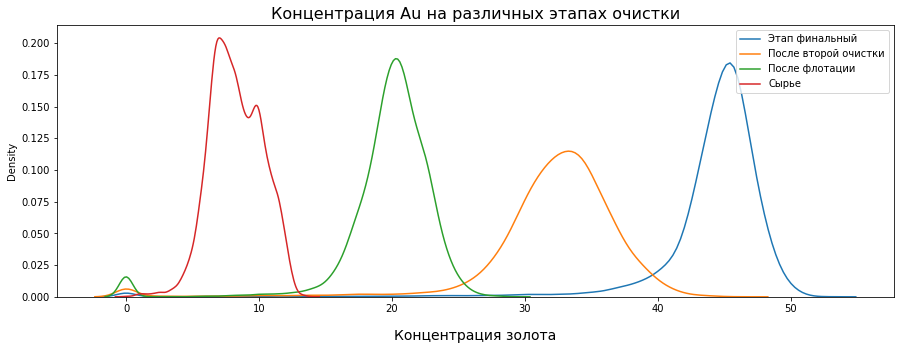

In [23]:
plt.figure(figsize=(15, 5))
plt.title('Концентрация Au на различных этапах очистки', fontsize=16)
plt.xlabel('Концентрация золота', labelpad=15, fontsize=14)
sns.kdeplot(data=full['final.output.concentrate_au'], label = 'Этап финальный')
sns.kdeplot(data=full['primary_cleaner.output.concentrate_au'], label = 'После второй очистки')
sns.kdeplot(data=full['rougher.output.concentrate_au'], label = 'После флотации')
sns.kdeplot(data=full['rougher.input.feed_au'], label = 'Сырье')
plt.legend()

plt.show()


In [24]:
concentrate_pb = full[['rougher.input.feed_pb',
                       'rougher.output.concentrate_pb',
                      'primary_cleaner.output.concentrate_pb',
                       'final.output.concentrate_pb'
                      ]].mean(axis=0)
concentrate_pb

rougher.input.feed_pb                    3.585850
rougher.output.concentrate_pb            7.606272
primary_cleaner.output.concentrate_pb    9.810430
final.output.concentrate_pb              9.978817
dtype: float64

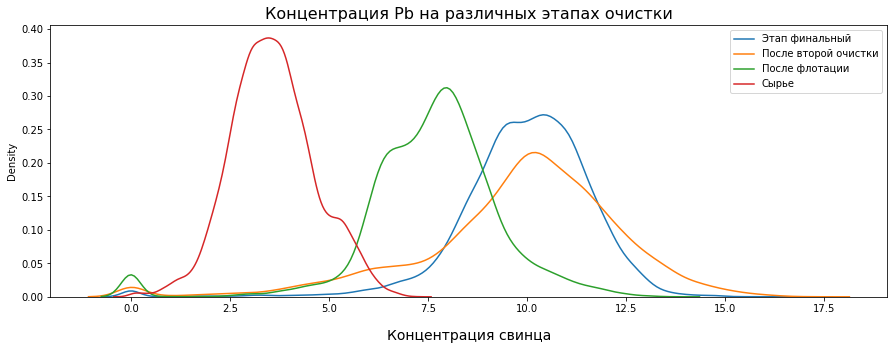

In [25]:
plt.figure(figsize=(15, 5))
plt.title('Концентрация Pb на различных этапах очистки', fontsize=16)
plt.xlabel('Концентрация свинца', labelpad=15, fontsize=14)
sns.kdeplot(data=full['final.output.concentrate_pb'], label = 'Этап финальный')
sns.kdeplot(data=full['primary_cleaner.output.concentrate_pb'], label = 'После второй очистки')
sns.kdeplot(data=full['rougher.output.concentrate_pb'], label = 'После флотации')
sns.kdeplot(data=full['rougher.input.feed_pb'], label = 'Сырье')
plt.legend()

plt.show()


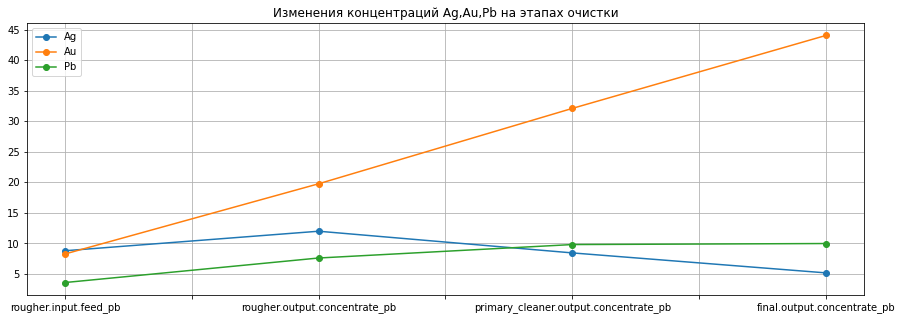

In [26]:
concentrate_ag.plot(style='-o', grid=True, figsize=(15,5), label='Ag') 
concentrate_au.plot(style='-o', grid=True, figsize=(15,5), label='Au')
concentrate_pb.plot(style='-o', grid=True, figsize=(15,5), label='Pb')

plt.title('Изменения концентраций Ag,Au,Pb на этапах очистки')
plt.legend()
plt.show()

Вывод: Анализ концентрации металлов показал,что 
       концентрация золота Au значительно увеличивается на каждом этапе обработки сырья;
       
       концентрация Ag падает с этапа флотации;
       
       концентрация Pb растет от этапа к этапу, но низкими темпами

2.2. Сравнение распределения размеров гранул сырья на обучающей и тестовой выборках

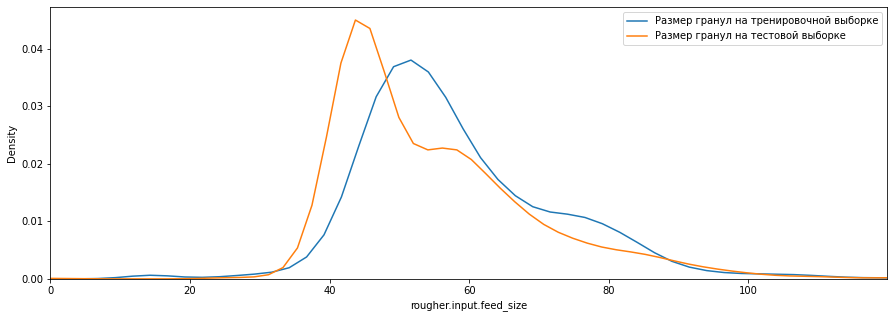

In [27]:
plt.figure(figsize=(15, 5))
plt.xlim(0, train['rougher.input.feed_size'].mean() + train['rougher.input.feed_size'].mean())
sns.kdeplot(data=train['rougher.input.feed_size'], label = 'Размер гранул на тренировочной выборке')
sns.kdeplot(data=test['rougher.input.feed_size'], label = 'Размер гранул на тестовой выборке')
plt.legend()
plt.show()

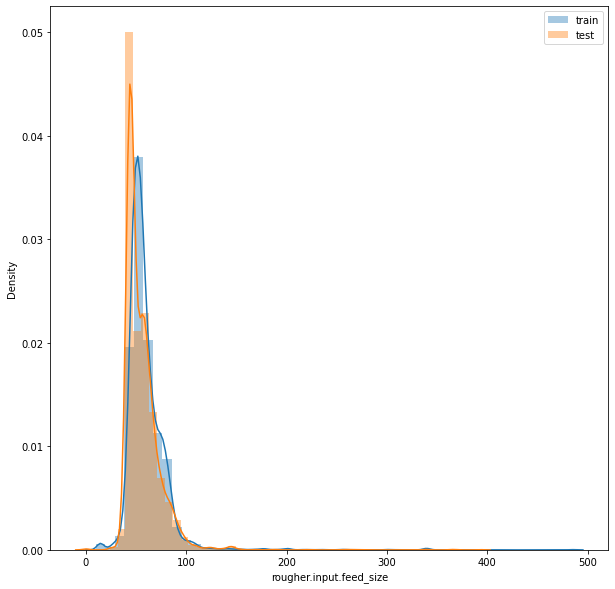

In [28]:
plt.figure(figsize=(10, 10))
sns.distplot(train['rougher.input.feed_size'].dropna(), label='train')
sns.distplot(test['rougher.input.feed_size'].dropna(), label='test')
plt.legend()
plt.show()

вывод: распределения похожи,что говорит об однородности данных размеров сырья в выборках train и test

# 2.3. Исследование суммарной концентрации всех веществ на разных стадиях: в сырье, в черновом и финальном концентратах

In [29]:
#Исходное сырье
full['rougher.input.sum'] = (full['rougher.input.feed_ag'] + full['rougher.input.feed_au'] 
                                  + full['rougher.input.feed_pb'] + full['rougher.input.feed_sol'])

In [30]:
# Черновая смесь
full['rougher.output.sum'] = (full['rougher.output.concentrate_ag'] + full['rougher.output.concentrate_au']
                                  + full['rougher.output.concentrate_pb'] + full['rougher.output.concentrate_sol'])

In [31]:
#сумма концентраций металлов после первичной очистки
full['primary.output.sum'] = (full['primary_cleaner.output.concentrate_ag'] + full['primary_cleaner.output.concentrate_au']
                                  + full['primary_cleaner.output.concentrate_pb'] + full['primary_cleaner.output.concentrate_sol'])

In [32]:
#сумма концентраций металлов после финальной очистки
full['final.output.sum'] = (full['final.output.concentrate_ag'] + full['final.output.concentrate_au']
                                  + full['final.output.concentrate_pb'] + full['final.output.concentrate_sol'])


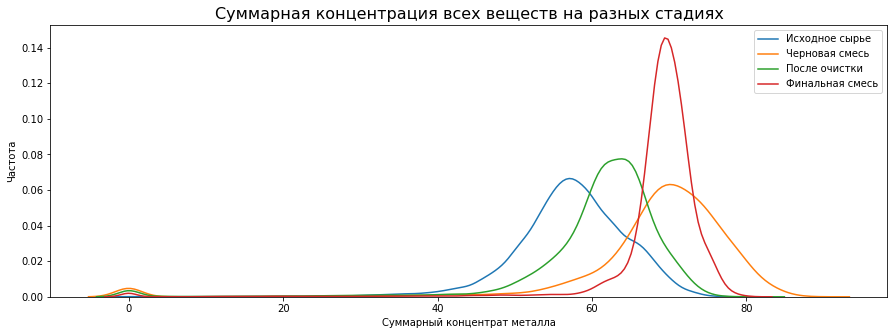

In [33]:
plt.figure(figsize=(15, 5))
plt.title('Суммарная концентрация всех веществ на разных стадиях', fontsize=16)
sns.kdeplot(data=full['rougher.input.sum'], label = 'Исходное сырье')
sns.kdeplot(data=full['rougher.output.sum'], label = 'Черновая смесь')
sns.kdeplot(data=full['primary.output.sum'], label = 'После очистки')
sns.kdeplot(data=full['final.output.sum'], label = 'Финальная смесь')
plt.xlabel("Суммарный концентрат металла")
plt.ylabel("Частота")
plt.legend()

вывод: много выбросов , много значений от 0 до примерно 30, их частота нулевая

Строю ящики с усами суммарных концентраций веществ, чтобы увидеть распределения этих значений.

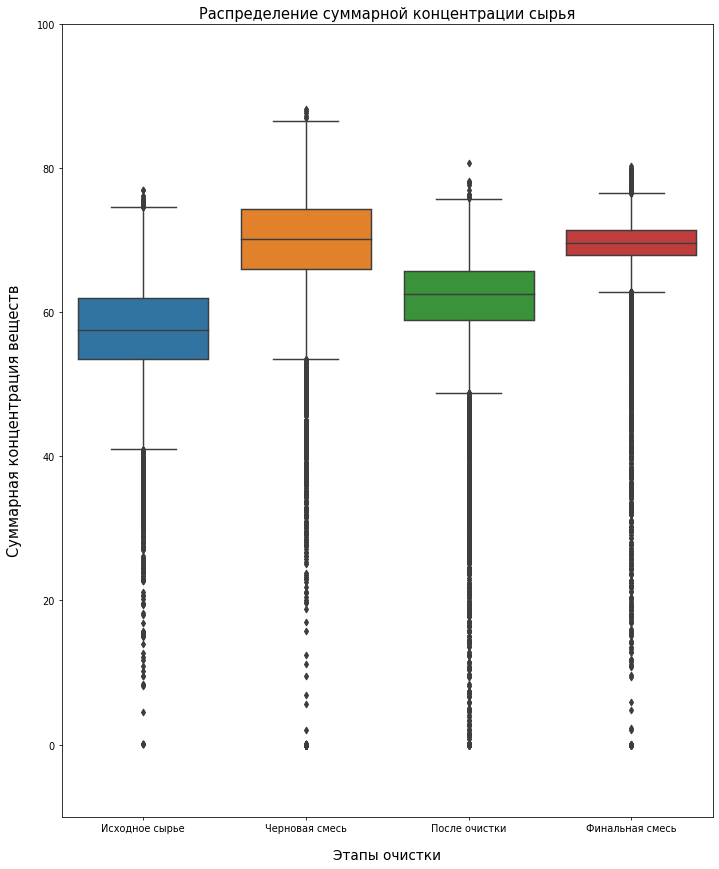

In [34]:
plt.figure(figsize=(12,15), dpi= 70)
sns.boxplot(data=full[['rougher.input.sum', 'rougher.output.sum', 'primary.output.sum', 'final.output.sum']])
plt.title('Распределение суммарной концентрации сырья', fontsize=15)
plt.ylim(-10, 100)
plt.xlabel('Этапы очистки', labelpad=15, fontsize=14)
plt.ylabel('Суммарная концентрация веществ', labelpad=15, fontsize=15)
plt.xticks(np.arange(4), ('Исходное сырье', 'Черновая смесь', 'После очистки', 'Финальная смесь'))
plt.show()

Вывод: много выбросов находятся в первом квартиле, их можно удалить,чтобы не мешали обучению модели.

In [35]:
final_output_concentrate = (train['final.output.concentrate_ag'] + train['final.output.concentrate_au']
                                  + train['final.output.concentrate_pb'] + train['final.output.concentrate_sol'])


train_clean = train.query('@final_output_concentrate > 30')

In [36]:
train_clean['final.output.sum'] = (train_clean['final.output.concentrate_ag'] + train_clean['final.output.concentrate_au']
                                  + train_clean['final.output.concentrate_pb'] + train_clean['final.output.concentrate_sol'])

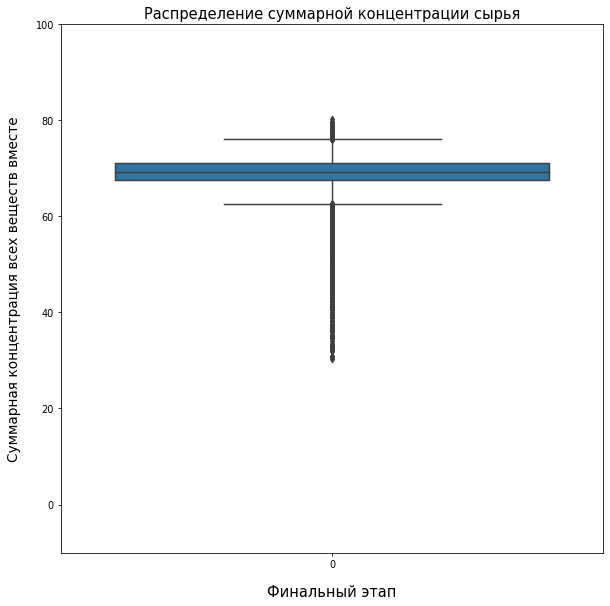

In [37]:
plt.figure(figsize=(10,10), dpi= 70)
sns.boxplot(data=train_clean['final.output.sum'])
plt.title('Распределение суммарной концентрации сырья', fontsize=15)
plt.ylim(-10, 100)
plt.xlabel('Финальный этап', labelpad=15, fontsize=15)
plt.ylabel('Суммарная концентрация всех веществ вместе', labelpad=15, fontsize=14)
plt.show()

вывод: избавился от выбросов, ихстало меньше, ящик с усами выглядит лучше

## Модель

# 3.1. Функция для вычисления итоговой sMAPE

Функция для вычисления sMAPE:

In [38]:
def sMAPE_calc(y_target, y_predict):
    smape = np.mean(abs(y_target - y_predict) / ((abs(y_target) + abs(y_predict)) / 2)) * 100
    return smape

Функция для вычисления финального sMAPE:

In [39]:
def final_sMAPE_calc(smape_rougher, smape_final):
    return (0.25*smape_rougher + 0.75*smape_final)

# 3.2. Обучение разных моделей.

Разделяю обучающую выборку на признаки:

In [40]:
features_train = np.array(train.drop(['rougher.output.recovery', 'final.output.recovery',
                                     'rougher.output.concentrate_au', 'primary_cleaner.output.tail_pb',
                                      'final.output.concentrate_au', 'primary_cleaner.output.concentrate_pb',
                                      'final.output.tail_sol',
                                      'rougher.calculation.floatbank10_sulfate_to_au_feed',
                                      'rougher.output.tail_sol', 'final.output.tail_au',
                                      'primary_cleaner.output.concentrate_ag',
                                      'rougher.calculation.floatbank11_sulfate_to_au_feed',
                                      'rougher.output.tail_ag', 'rougher.output.tail_pb',
                                      'secondary_cleaner.output.tail_pb', 'final.output.tail_ag',
                                      'final.output.concentrate_sol', 'primary_cleaner.output.tail_au',
                                      'secondary_cleaner.output.tail_sol', 'secondary_cleaner.output.tail_ag',
                                      'rougher.output.tail_au', 'rougher.output.concentrate_ag',
                                      'primary_cleaner.output.concentrate_sol', 'final.output.concentrate_pb',
                                      'final.output.concentrate_ag', 'secondary_cleaner.output.tail_au',
                                      'rougher.output.concentrate_pb', 'rougher.output.concentrate_sol',
                                      'primary_cleaner.output.tail_sol',
                                      'rougher.calculation.sulfate_to_au_concentrate',
                                      'final.output.tail_pb', 'primary_cleaner.output.concentrate_au',
                                      'primary_cleaner.output.tail_ag', 'rougher.calculation.au_pb_ratio'], 
                                     axis=1)) 

#кроме целевых, убираю признаки, которых нет в test:

target_train_rougher = np.array(train['rougher.output.recovery'])
target_train_final = np.array(train['final.output.recovery'])



In [41]:
for sample in [features_train, target_train_rougher, target_train_final]:
    print(sample.shape)

(14149, 52)
(14149,)
(14149,)


In [42]:
score = make_scorer(sMAPE_calc, greater_is_better = False) 

Применяю make_pipeline для Случайного леса, Дерева решений и Регрессии:

In [43]:
# (разбиваю на ячейки,чтобы выполнялись быстрее)
model_rfr = make_pipeline(StandardScaler(), RandomForestRegressor())

In [44]:
model_dtr = make_pipeline(StandardScaler(), DecisionTreeRegressor())

In [45]:
model_lr = make_pipeline(StandardScaler(), LinearRegression())

Параметры для моделей:

In [46]:
parameters_rfr = {'randomforestregressor__n_estimators':[1,100],
                  'randomforestregressor__max_depth':[1,10],
                  'randomforestregressor__random_state':[12345]}

In [47]:
parameters_dtr = {'decisiontreeregressor__max_depth':[1,10]}

In [48]:
parameters_lr = {'linearregression__normalize':[False]}

GridSearchCV для перебора гиперпараметров и для кросс-валидации:

In [49]:
grid_rougher_rfr = GridSearchCV(model_rfr, param_grid=parameters_rfr, cv=5, scoring=score)
grid_final_rfr = GridSearchCV(model_rfr, param_grid=parameters_rfr, cv=5, scoring=score)

In [50]:
grid_rougher_dtr = GridSearchCV(model_dtr, param_grid=parameters_dtr, cv=5, scoring=score)
grid_final_dtr = GridSearchCV(model_dtr, param_grid=parameters_dtr, cv=5, scoring=score)

In [51]:
grid_rougher_lr = GridSearchCV(model_lr, param_grid=parameters_lr, scoring=score)
grid_final_lr = GridSearchCV(model_lr, param_grid=parameters_lr, scoring=score)

Обучаю модели:

In [52]:
grid_rougher_rfr.fit(features_train, target_train_rougher)
#grid_final_rfr.fit(features_train, target_train_final)

#grid_rougher_dtr.fit(features_train, target_train_rougher)
#grid_final_dtr.fit(features_train, target_train_final)

#grid_rougher_lr.fit(features_train, target_train_rougher)
#grid_final_lr.fit(features_train, target_train_final)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('randomforestregressor',
                                        RandomForestRegressor())]),
             param_grid={'randomforestregressor__max_depth': [1, 10],
                         'randomforestregressor__n_estimators': [1, 100],
                         'randomforestregressor__random_state': [12345]},
             scoring=make_scorer(sMAPE_calc, greater_is_better=False))

GridSearchCV(cv=5,

             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('randomforestregressor',
                                        RandomForestRegressor())]),
             param_grid={'randomforestregressor__max_depth': [1, 10],
                         'randomforestregressor__n_estimators': [1, 100],
                         'randomforestregressor__random_state': [12345]},
             scoring=make_scorer(sMAPE_calc, greater_is_better=False))

In [53]:
grid_final_rfr.fit(features_train, target_train_final)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('randomforestregressor',
                                        RandomForestRegressor())]),
             param_grid={'randomforestregressor__max_depth': [1, 10],
                         'randomforestregressor__n_estimators': [1, 100],
                         'randomforestregressor__random_state': [12345]},
             scoring=make_scorer(sMAPE_calc, greater_is_better=False))

In [54]:
print('Лучшие параметры : ', grid_final_rfr.best_params_)

лучшие параметры :  {'randomforestregressor__max_depth': 1, 'randomforestregressor__n_estimators': 100, 'randomforestregressor__random_state': 12345}


In [55]:
grid_rougher_dtr.fit(features_train, target_train_rougher)
grid_final_dtr.fit(features_train, target_train_final)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('decisiontreeregressor',
                                        DecisionTreeRegressor())]),
             param_grid={'decisiontreeregressor__max_depth': [1, 10]},
             scoring=make_scorer(sMAPE_calc, greater_is_better=False))

In [56]:
print('Лучшие параметры : ', grid_final_dtr.best_params_)

лучшие параметры :  {'decisiontreeregressor__max_depth': 1}


GridSearchCV(cv=5,

             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('decisiontreeregressor',
                                        DecisionTreeRegressor())]),
             param_grid={'decisiontreeregressor__max_depth': [1, 10]},
             scoring=make_scorer(sMAPE_calc, greater_is_better=False))

In [57]:
grid_rougher_lr.fit(features_train, target_train_rougher)
grid_final_lr.fit(features_train, target_train_final)

GridSearchCV(estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('linearregression',
                                        LinearRegression())]),
             param_grid={'linearregression__normalize': [False]},
             scoring=make_scorer(sMAPE_calc, greater_is_better=False))

GridSearchCV(estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('linearregression',
                                        LinearRegression())]),
                                        
             param_grid={'linearregression__normalize': [False]},
             scoring=make_scorer(sMAPE_calc, greater_is_better=False))


In [58]:
#определяю лучшую из моделей для 2 целевых признаков: 
best_score_rougher_rfr = grid_rougher_rfr.best_score_
best_score_final_rfr = grid_final_rfr.best_score_

best_score_rougher_dtr = grid_rougher_dtr.best_score_
best_score_final_dtr = grid_final_dtr.best_score_

best_score_rougher_lr = grid_rougher_lr.best_score_
best_score_final_lr = grid_final_lr.best_score_

print(' RandomForestRegressor лучший результат rougher =', best_score_rougher_rfr)
print(' DecisionTreeRegressor лучший результат rougher =', best_score_rougher_dtr)
print(' LinearRegression лучший результат rougher =', best_score_rougher_lr)
print()

print(' RandomForestRegressor лучший результат final =', best_score_final_rfr)
print(' DecisionTreeRegressor лучший результат final =', best_score_final_dtr)
print(' LinearRegression лучший результат final =', best_score_final_lr)

 RandomForestRegressor лучший результат rougher = -12.430723847714054
 DecisionTreeRegressor лучший результат rougher = -12.463376951515484
 LinearRegression лучший результат rougher = -12.612320871397836

 RandomForestRegressor лучший результат final = -10.82066080737953
 DecisionTreeRegressor лучший результат final = -11.037301695652351
 LinearRegression лучший результат final = -12.199823507661959


 RandomForestRegressor лучший результат rougher = -12.430723847714054

 DecisionTreeRegressor лучший результат rougher = -12.463376951515562

 LinearRegression лучший результат rougher = -12.612320871397836
 

 RandomForestRegressor лучший результат final = -10.82066080737953

 DecisionTreeRegressor лучший результат final = -11.037301695652443

 LinearRegression лучший результат final = -12.199823507661959

In [59]:
#final sMAPE для каждой модели:
final_smape_rfr = final_sMAPE_calc(best_score_rougher_rfr, best_score_final_rfr)
print(' RandomForestRegressor итоговое sMAPE =', final_smape_rfr)

final_smape_dtr = final_sMAPE_calc(best_score_rougher_dtr, best_score_final_dtr)
print(' DecisionTreeRegressor итоговое sMAPE =', final_smape_dtr)

final_smape_lr = final_sMAPE_calc(best_score_rougher_lr, best_score_final_lr)
print(' LinearRegression итоговое sMAPE =', final_smape_lr)

 RandomForestRegressor итоговое sMAPE = -11.223176567463161
 DecisionTreeRegressor итоговое sMAPE = -11.393820509618134
 LinearRegression итоговое sMAPE = -12.302947848595927


 RandomForestRegressor итоговое sMAPE = -11.223176567463161

 DecisionTreeRegressor итоговое sMAPE = -11.393820509618223

 LinearRegression итоговое sMAPE = -12.302947848595927

In [60]:
#на тестовой выборке final sMAPE по RandomForestRegressor:
features_test = np.array(test.drop(['rougher.output.recovery', 'final.output.recovery'], axis=1))
target_test_rouger = np.array(test['rougher.output.recovery'])
target_test_final = np.array(test['final.output.recovery'])

test_rogher = grid_rougher_rfr.predict(features_test) 
test_final = grid_final_rfr.predict(features_test)

rouger_smape_test = sMAPE_calc(target_test_rouger, test_rogher)
final_smape_test = sMAPE_calc(target_test_final, test_final)

final_smape = final_sMAPE_calc(rouger_smape_test, final_smape_test)
print('Симметричная средняя абсолютная процентная ошибка на тестовой выборке =', round(final_smape,3))

Симметричная средняя абсолютная процентная ошибка на тестовой выборке = 9.693


Симметричная средняя абсолютная процентная ошибка на тестовой выборке = 9.693

Вывод: 

       - Обучил  на тренировочной выборке 3 модели: случайный лес, дерево решений и линейную 
        регрессию, с применением кросс-валидации;
      
       - Лучшие метрики качества у Случайного леса. Провел проверку на тестовой выборке; 
      
       - Симметричная средняя абсолютная процентная ошибка на тестовой выборке равна 9.693.

##  Проверка модели на вменяемость

In [61]:
for strategy in ['mean', 'median']:
    dummy_rougher = DummyRegressor(strategy=strategy)
    dummy_final = DummyRegressor(strategy=strategy)
    
    dummy_rougher.fit(features_train, target_train_rougher)
    dummy_final.fit(features_train, target_train_final)
    
    rougher = dummy_rougher.predict(test)
    final = dummy_final.predict(test)
    
    final_smape = final_sMAPE_calc(sMAPE_calc(target_test_rouger, rougher),
                                   sMAPE_calc(target_test_final, final))

    print('Для стратегии', strategy, 'итоговая sMAPE =', round(final_smape,3))

Для стратегии mean итоговая sMAPE = 10.29
Для стратегии median итоговая sMAPE = 9.48


Вывод: По сравнению с константной моделью значения метрик оказались выше. 
       Поэтому считаю, что модель RandomForestRegressor прошла проверку на вменяемость

##  Общий вывод

В результате данной работы были проведены следующие исследования и сделаны выводы:
    
    1. Изучил и подготовил для анализа данные:
        
        - во всех представленных таблицах имеются пропуски;

        - в test нет части признаков, которые есть в full и train;

        - целевые признаки - rougher.output.recovery и final.output.recovery;

        - дубликатов нет.
       
     2. Проверил правильность расчета эффективности обогащения:
     
        -полученные значения МАЕ близки к 0, следовательно эффективность обогащения рассчитана правильно.
        
     3. Добавил целевые признаки в  выборку test из full по совпадению даты;

        Подтвердил правильность расчета эффективности обогащения в тренировочной выборке;

        Избавился от пропусков в  выборках;
        
     4. Анализ концентрации металлов показал,что концентрация золота Au значительно увеличивается 
        на каждом этапе обработки сырья;

        концентрация Ag падает с этапа флотации;

        концентрация Pb растет от этапа к этапу, но низкими темпами
       
       
      5. Обучил  на тренировочной выборке 3 модели: случайный лес, дерево решений и линейную 
        регрессию, с применением кросс-валидации;
      
         Лучшие метрики качества у Случайного леса. Провел проверку на тестовой выборке; 
      
         Симметричная средняя абсолютная процентная ошибка на тестовой выборке равна 9.693.
         
         Прототипом модели машинного обучения для «Цифры» является RandomForestRegressor: модель 
         предсказывает коэффициент восстановления золота из золотосодержащей руды наилучшим образом, 
         в т.ч. при проверке на вменяемость.

## Чек-лист готовности проекта

- [x]  Jupyter Notebook открыт
- [x ]  Весь код выполняется без ошибок
- [x ]  Ячейки с кодом расположены в порядке выполнения
- [x ]  Выполнен шаг 1: данные подготовлены
    - [x ]  Проверена формула вычисления эффективности обогащения
    - [ x]  Проанализированы признаки, недоступные в тестовой выборке
    - [x ]  Проведена предобработка данных
- [x ]  Выполнен шаг 2: данные проанализированы
    - [x ]  Исследовано изменение концентрации элементов на каждом этапе
    - [x ]  Проанализированы распределения размеров гранул на обучающей и тестовой выборках
    - [ x]  Исследованы суммарные концентрации
- [x ]  Выполнен шаг 3: построена модель прогнозирования
    - [x ]  Написана функция для вычисления итогового *sMAPE*
    - [ x]  Обучено и проверено несколько моделей
    - [ x]  Выбрана лучшая модель, её качество проверено на тестовой выборке